### Начинаем учебные соревнования 

13 марта 2023 года, https://www.kaggle.com/

### Импортируем полезные библиотеки

In [564]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from datetime import datetime

%matplotlib inline

from sklearn import tree

from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import numpy as np

from IPython.display import HTML
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


In [722]:
import calendar

### Открыть файлы

1) Посмотреть файлы в архиве zip (имя и размер)

In [534]:
from zipfile import ZipFile

ZipFile('/Users/tony_builder/Documents/GitHub/kaggle/datas/store-sales-time-series-forecasting.zip').infolist()

[<ZipInfo filename='holidays_events.csv' compress_type=deflate file_size=22309 compress_size=2232>,
 <ZipInfo filename='oil.csv' compress_type=deflate file_size=20580 compress_size=5822>,
 <ZipInfo filename='sample_submission.csv' compress_type=deflate file_size=342153 compress_size=65352>,
 <ZipInfo filename='stores.csv' compress_type=deflate file_size=1387 compress_size=490>,
 <ZipInfo filename='test.csv' compress_type=deflate file_size=1022269 compress_size=152503>,
 <ZipInfo filename='train.csv' compress_type=deflate file_size=121800373 compress_size=21820633>,
 <ZipInfo filename='transactions.csv' compress_type=deflate file_size=1552637 compress_size=368309>]

2. Считать конкретный файл в zip архиве и прочитать его (например через pandas.read)

In [ ]:
import pandas as pd

with ZipFile('/Users/tony_builder/Documents/GitHub/kaggle/datas/store-sales-time-series-forecasting.zip', 'r') \
    as zip_file:
    holiday_df = pd.read_csv(zip_file.open('holidays_events.csv'))
    oil_df = pd.read_csv(zip_file.open('oil.csv'))
    sample_submission_df = pd.read_csv(zip_file.open('sample_submission.csv'))
    test = pd.read_csv(zip_file.open('test.csv'))
    train = pd.read_csv(zip_file.open('train.csv'))
    transactions = pd.read_csv(zip_file.open('transactions.csv'))
    stores_df = pd.read_csv(zip_file.open('stores.csv'))



### Задать цель

Описание: 
1) есть тренировочные данные , содержащие продукцию, о которых известно:
- идентификационный номер товара
- дата его продажи **с 1 января 2013 по 15 августа 2017**
- место его продажи (номер магазина)
- к чему относится этот товар (авто, красота, морепродукты, книги и пр)
- рекламировался ли он в конкретную дату
- какой объем продаж товара сделан в конкретную дату
2) Целевая переменная - непосредственно количество продаж товара
3) вспомогательные датасэты содержат дополнительную инфу (например об общей выручке магазина, которую он делал в конкретную дату) или информация о праздниках



Файл для предсказаний: информация о продаваемых товарах в последующие 15 дней 
- **с 16 августа 2017 по 31 августа 2017**

Что нужно:

        предсказать целевую переменную (объем продаж) некоторых семейств товаров в конкретные даты и в конкретных магазинах, зная информацию о том, как будет рекламироваться товар в эти даты

Стратегия:
1) наполнить тренировочный датасэт данными:
- информацию о том, является ли день продажи выходным (теоретически, в выходные дни продажи выше, чем в обычные)

- информация о стоимости на нефть в текущий день - т.к продажи товаров так же могут зависеть от цены на нефть

- Заработная плата в бюджетной сфере выплачивается каждые две недели 15 числа и в последний день месяца. Это может повлиять на продажи в супермаркетах.

- Землетрясение магнитудой 7,8 произошло в Эквадоре 16 апреля 2016 года (15 неделя года). Люди объединились для оказания помощи, пожертвовав воду и другие предметы первой необходимости, что сильно повлияло на продажи в супермаркетах в течение нескольких недель после землетрясения.

###  Работаем с датасетом по праздникам

In [ ]:

holiday_df['datetime'] = pd.to_datetime(holiday_df.date, format='%Y-%m-%d')
holiday_df =  holiday_df.drop('date',axis=1)\
.rename(columns={'datetime':'date'})\
[['date', 'type', 'locale', 'locale_name', 'description', 'transferred']]

holiday_df['year'] = holiday_df.date.dt.year
holiday_df['month'] = holiday_df.date.dt.month
holiday_df['day'] = holiday_df.date.dt.day

holiday_df

,date,type,locale,locale_name,description,transferred,year,month,day
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21
...,...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,2017,12,22
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,2017,12,23
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,2017,12,24
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,2017,12,25


Что знаем о таблице праздников:
1) Holiday 
- National: 8 перенесенных (рабочие дни для всех! ) и 52 без переноса (праздник для всех)
- Regional: 24 праздника только для некоторых ШТАТОВ
- Local: 4 перенесенных (рабочие дни для ВСЕХ!) и 133 без переноса (нерабочие только для некоторых ГОРОДОВ)

2) Event и Bridge :  61 нерабочие для всех

3) Additional: 
- National: 40 праздники для всех
- Local: 11 праздники для некоторых ГОРОДОВ

4) Transfer:
- National: 8 дней нерабочие для всех
- Local : 4 дня нерабочие только для некоторых ГОРОДОВ

5) Work day - РАБОЧИЕ для всех, даже если это суббота или воскресенье


Нужно разделить все дни на два типа: **праздничный/непраздничный**


        Разделим таблицу (350 дней) на несколько частей:
        - нерабочие для всех
        - нерабочие для городов
        - нерабочие для штатов
        - рабочие не взирая на то, что это суббота

In [ ]:
# нерабочие для всех (161 день за все годы)
holidays_for_all = holiday_df[holiday_df.locale == 'National'].\
    query("transferred == False").\
    query("type != 'Work Day' ")

holidays_for_all['workday'] = holidays_for_all.transferred.map(int)

holidays_for_all.head()

,date,type,locale,locale_name,description,transferred,year,month,day,workday
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,2012,8,10,0
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2012,10,12,0
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False,2012,11,2,0
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False,2012,11,3,0
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False,2012,12,21,0


список праздников для всех содержит дубликаты по датам, но они все государственные и неперенесенные, поэтому их все можно смело дропнуть

In [ ]:
# найти все дубликаты в столбце датасэта и вывести на экран
holidays_for_all[holidays_for_all.duplicated('date')]

,date,type,locale,locale_name,description,transferred,year,month,day,workday
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False,2012,12,24,0
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False,2012,12,31,0
157,2014-12-26,Additional,National,Ecuador,Navidad+1,False,2014,12,26,0
236,2016-05-01,Event,National,Ecuador,Terremoto Manabi+15,False,2016,5,1,0
243,2016-05-07,Event,National,Ecuador,Terremoto Manabi+21,False,2016,5,7,0
245,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,2016,5,8,0


In [ ]:
# нерабочие для городов (148 дней за все годы)

holidays_for_cities = holiday_df[holiday_df.locale == 'Local'].\
    query("transferred == False").\
    query("type != 'Work Day' ")

holidays_for_cities['workday'] = holidays_for_cities.transferred.map(int)


holidays_for_cities.head()


# здесь дубликаты дат нельзя удалять, потому что эти даты могут быть праздничными сразу для двух городов,
# а значит для нескольких магазинов

,date,type,locale,locale_name,description,transferred,year,month,day,workday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12,0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14,0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21,0
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False,2012,5,12,0


In [376]:
# переименуем столбец locale_name в столбец city для удобства слияния
holidays_for_cities = holidays_for_cities.rename(columns={'locale_name': 'city'})

,date,type,locale,city,description,transferred,year,month,day,workday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12,0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14,0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21,0
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False,2012,5,12,0
...,...,...,...,...,...,...,...,...,...,...
338,2017-11-12,Holiday,Local,Ambato,Independencia de Ambato,False,2017,11,12,0
339,2017-12-05,Additional,Local,Quito,Fundacion de Quito-1,False,2017,12,5,0
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False,2017,12,8,0
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False,2017,12,8,0


In [479]:
# нерабочие для штатов (24 дня за все годы)

holidays_for_states = holiday_df[holiday_df.locale == 'Regional']

# добавим столбец нерабочих дней
holidays_for_states['workday'] = holidays_for_states.transferred.map(int)

# переименуем locale_name в имя штата (в этой таблице остались только имена штатов)
holidays_for_states = holidays_for_states.rename(columns= {'locale_name': 'state'})
holidays_for_states

/var/folders/9t/0d2y6zvs0pn1b5hks81yn5jw0000gn/T/ipykernel_71953/1123250828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_for_states['workday'] = holidays_for_states.transferred.map(int)


,date,type,locale,state,description,transferred,year,month,day,workday
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1,0
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,2012,6,25,0
23,2012-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False,2012,11,6,0
24,2012-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False,2012,11,7,0
47,2013-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2013,4,1,0
58,2013-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,2013,6,25,0
76,2013-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False,2013,11,6,0
77,2013-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False,2013,11,7,0
96,2014-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2014,4,1,0
112,2014-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,2014,6,25,0


In [491]:
# рабочие для всех (17 дней за все годы): либо перенесенные праздники , либо замененные на рабочие дни

workdays_for_all = holiday_df[(holiday_df.type == 'Work Day') | (holiday_df.transferred == True)]
workdays_for_all.head()

,date,type,locale,locale_name,description,transferred,year,month,day
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,2012,10,9
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False,2013,1,5
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False,2013,1,12
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,2013,10,9
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,2014,10,9


### Работаем с тренировочным датасэтом: наполняем данными о выходных и рабочих днях

In [ ]:
train['datetime'] = pd.to_datetime(train.date, format='%Y-%m-%d')
train =  train.drop('date',axis=1)\
.rename(columns={'datetime':'date'})\
[['id', 'date', 'store_nbr', 'family', 'onpromotion', 'sales']]

#train['year'] = train.date.dt.year
#train['month'] = train.date.dt.month
#train['day'] = train.date.dt.day
train['week_day'] = train.date.dt.day_of_week

train

,id,date,store_nbr,family,onpromotion,sales,week_day
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1
1,1,2013-01-01,1,BABY CARE,0,0.000,1
2,2,2013-01-01,1,BEAUTY,0,0.000,1
3,3,2013-01-01,1,BEVERAGES,0,0.000,1
4,4,2013-01-01,1,BOOKS,0,0.000,1
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1


Объединим данные по продажам с данными:
- о том, где находятся магазины (город,штат)
- о том, какие из этих дней являются праздничными, причем даты Holidays yужно отфильтровать в диапазон (01.01.23 - 15.08.17), потому что train data имеет именно такой диапазон

In [ ]:
# примерджим в датасэт train информацию о местонахождении магазинов
train_filled = train.merge(stores_df, on='store_nbr', 
            how='outer').drop(['type', 'cluster'], axis=1)

# Отберем только тот диапазон дней, который соответствует тренировочному датасэту, уберем дубликаты дат
holiday_temp = holidays_for_all[(holidays_for_all.date <= '2017-08-15') &\
                                        (holidays_for_all.date >='2013-01-01')]\
                                        [['date', 'workday']].\
                                        drop_duplicates('date')

# добавим столбец, описывающий - выходной это день или рабочий
train_filled['workday'] = train_filled['date'].map(holiday_temp.set_index('date')['workday'])

train_filled


,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,NaN
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,NaN
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,NaN
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,NaN


Объединяем информацию о праздниках в некоторых городах с тренировочным датасетом
- получится два столбца workday - потому что мы мерджим две таблицы по столбцам ДАТА и ГОРОД, но в эьтих таблицах в обеих присутствует столбец WORKDAY, поэтому появятся дубли столбцов

- чтобы привести в нормальный вид - нужно все значения NAN  в столбце  Х заполнить  значениями из столбца У
- а теперь дропнуть ненужные столбцы Х и У

Остались дубликаты - 264 строки:
- убедимся, что это дубликаты по ID
- проверим, что это действительно полная копия тех строк, что уже есть (через dupicates('id')) - и удалим все эти строки

In [469]:
train_filled = pd.merge(train_filled,
                  holidays_for_cities[['date', 'city', 'workday']], 
                  how='left', 
                  on=['date', 'city'])

train_filled['workday'] = train_filled['workday_y'].fillna(train_filled['workday_x'])
train_filled = train_filled.drop(['workday_x', 'workday_y'], axis=1)

train_filled = train_filled.drop_duplicates('id')

train_filled

,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0
...,...,...,...,...,...,...,...,...,...,...
3001147,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,NaN
3001148,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,NaN
3001149,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,NaN
3001150,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,NaN


Аналогично примерджим сюда информацию о праздниках, которые действительны только в НЕКОТОРЫХ штатах

In [488]:
train_filled = pd.merge(train_filled,
                  holidays_for_states[['date', 'state', 'workday']], 
                  how='left', 
                  on=['date', 'state'])

train_filled['workday'] = train_filled['workday_y'].fillna(train_filled['workday_x'])
train_filled = train_filled.drop(['workday_x', 'workday_y'], axis=1)


train_filled

,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,NaN
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,NaN
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,NaN
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,NaN


Осталось указать два типа дней:
- рабочие дни несмотря ни на что
- нерабочие дни суббота и воскресенье

Остальные дни автоматически будут рабочими

In [526]:
# фильтруем тренировоочный датасет по значениям: 
# - если день недели 5 или 6 (суббота или воскресенье) 
# - если этот день не один из дней, которые являются рабочими для всех!
# ставим отрицание(чтобы получить все оставшиеся значения) и указываем, что для всех остальных применить значение 0

# и в конце концов заполняем все оставшиеся значения NAN единицами - это РАБОЧИЕ дни

train_filled.workday = train_filled.workday.where\
    (~((train_filled.week_day.isin([5,6])) & (~train_filled.date.isin(workdays_for_all.date))), 
    other= 0)\
    .fillna(1)

# в итоге получаем датасет, в котором каждому дню присвоено значение 1/0 (рабочий/нерабочий)
# всего нерабочих: 1 020 855 дней за весь период
# всего рабочих: 1 980 033 дней за весь период
train_filled.groupby('workday').agg({'id':'count'})



,id
workday,
0.0,1020855
1.0,1980033


**ВАЖНО ПОМНИТЬ!** дни могут быть нерабочими только для некоторых штатов или городов!

### Тренировочный датасет: наполняем информацией о выплате запрплаты работникам

Просуммируем все продажи применительно к каждому дню и каждому магазину

Цель: выявить как меняются продажи в зависимости от выплаты зарплаты дважды в месяц

In [787]:
# вспомогательная функция для вывода распределения объема продаж для каждого магазина в конкретном году

def sales_in_year(store, year, alldays=False):
      from datetime import datetime
      start, end = datetime(year,1,1), datetime(year,12,31)

      # суммируем продажи по каждой дате для каждого магазина
      temp_df = train_filled.groupby(['date', 'store_nbr'], as_index=False).agg({'sales': 'sum'}).\
            query("@start <= date <= @end ").\
            query("store_nbr == @store")\
            .drop('store_nbr', axis=1)
      
      # добавим графу недели для читабельности
      temp_df['weeks'] = temp_df.date.dt.isocalendar().week
      
      # присоединим последние четыре дня года  к последней неделе года (чтобы они не переходили на первую неделю)
      import isoweek
      
      number_weeks =isoweek.Week.last_week_of_year(year)[1]
      temp_df.weeks = temp_df.weeks.where(~(temp_df.date.isin([datetime(year,12,28), 
                                                               datetime(year,12,29),
                                                               datetime(year,12,30),
                                                               datetime(year,12,31)])), 
                                                other= number_weeks)
      
      # итоговый датасет (с неделями или по каждому дню) вывести в зависсимости от показателя alldays:
      # - если alldays=False по умолчанию, то вывести только для недель
      # - если alldays =True (прописать), то вывести для каждого дня
      result_df = (temp_df.groupby('weeks', as_index=False).agg({'sales':'sum'}), 
                   temp_df)\
                   [alldays]
      
      xlab = ('weeks', 'date')[alldays]


      return result_df


In [652]:
# вспомогательная функция построения распределения выручки для каждого магазина в каждом году

def sales_in_year_plot(store, year, alldays=False):
    xlab = ('weeks', 'date')[alldays]
    # зададим размер графика для читабельности
    sns.set(rc={'figure.figsize': (12,6)}) 
    
    return sales_in_year(store,year, alldays=False).\
        set_index('weeks').\
        sales.plot(kind='bar', xlabel=xlab)

Поиграв с номерами магазинов и годами можно убедиться в том, что:
- с начала года до 49 недели наблюдается относительно равномерная картина выручки
- в конце года в основном выручка заметно вырастает (предпраздничные покупки , начиная с 49 недели)

- в 2016 году на 15 неделе действительно наблюдается рост покупок после землетрясения

- на неделе, предшествующей зарплатной неделе, продажи обычно снижаются, люди экономят

- есть годы, в которых наблюдается резкий скачок продаж в году, который не снижается до самого конца (полагаю, связано с ростом стоимости на нефть)

<AxesSubplot: xlabel='weeks'>

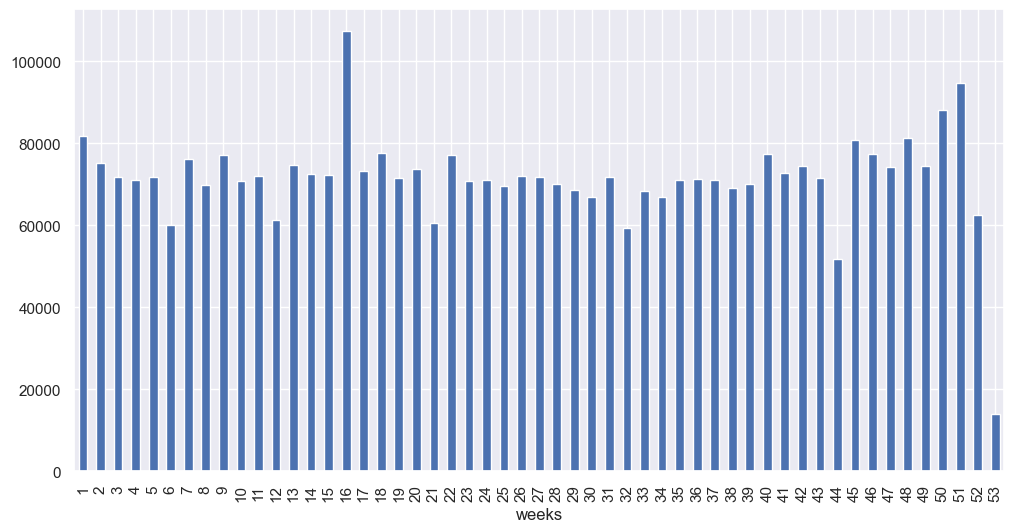

In [788]:
sales_in_year_plot(store=1, year=2016)

<AxesSubplot: xlabel='weeks'>

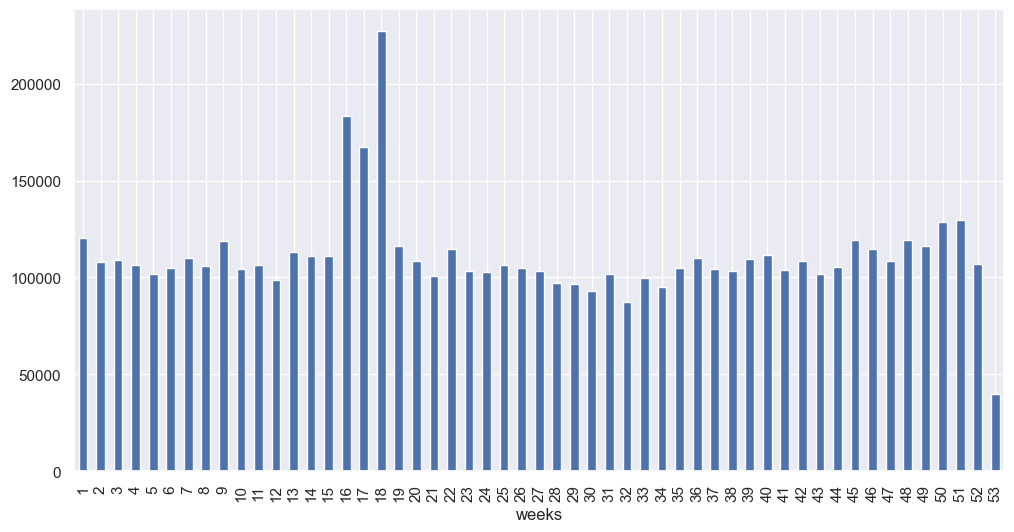

In [789]:
sales_in_year_plot(store=2, year=2016)

Добавим информацию о том, является ли день датой получения зарплаты

- сначала нужно выделить 15 число и ПОСЛЕДНИЙ ДЕНЬ МЕСЯЦА (это может быть 28, 29,30,31 число)

In [715]:
train_filled

,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday,oil_price_change
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0,0.00
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0,0.00
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0,0.00
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0,0.00
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,1.0,-0.04
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,1.0,-0.04
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,1.0,-0.04
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,1.0,-0.04


Добавим столбец " последний день месяца"

In [730]:
train_filled['month_last_day'] = train_filled.date.apply(lambda x: calendar.monthrange(x.year,x.month)[1])

In [733]:
train_filled['salary_day'] = ((train_filled.date.dt.day == train_filled.month_last_day) | \
                              (train_filled.date.dt.day == 15) )

train_filled.salary_day = train_filled.salary_day.map(int)

In [736]:
train_filled = train_filled.drop(['week_day', 'month_last_day'], axis=1)

In [737]:
train_filled

,id,date,store_nbr,family,onpromotion,sales,city,state,workday,oil_price_change,salary_day
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,Quito,Pichincha,0.0,0.00,0
1,1,2013-01-01,1,BABY CARE,0,0.000,Quito,Pichincha,0.0,0.00,0
2,2,2013-01-01,1,BEAUTY,0,0.000,Quito,Pichincha,0.0,0.00,0
3,3,2013-01-01,1,BEVERAGES,0,0.000,Quito,Pichincha,0.0,0.00,0
4,4,2013-01-01,1,BOOKS,0,0.000,Quito,Pichincha,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,Quito,Pichincha,1.0,-0.04,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,Quito,Pichincha,1.0,-0.04,1
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,Quito,Pichincha,1.0,-0.04,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,Quito,Pichincha,1.0,-0.04,1


### Тренировочный датасет: наполняем данными о стоимости нефти

In [631]:
# сначала обработаем исходный датасет по нефти: поменяем дату, заполним пустые значения котировки(цены) на предыдущее

oil_df['date_dt'] = pd.to_datetime(oil_df.date)
oil_df = oil_df.drop('date', axis=1).rename(columns={'date_dt':'date'})[['date','dcoilwtico']]
oil_df= oil_df.fillna(method='ffill').fillna(93.14)

# добавим столбцы год и месяц
oil_df['year'] = oil_df.date.dt.year
oil_df['month'] = oil_df.date.dt.month

oil_df


,date,dcoilwtico,year,month
0,2013-01-01,93.14,2013,1
1,2013-01-02,93.14,2013,1
2,2013-01-03,92.97,2013,1
3,2013-01-04,93.12,2013,1
4,2013-01-07,93.20,2013,1
...,...,...,...,...
1213,2017-08-25,47.65,2017,8
1214,2017-08-28,46.40,2017,8
1215,2017-08-29,46.46,2017,8
1216,2017-08-30,45.96,2017,8


Построим распределение усредненной цены  нефти по годам и месяцам

In [648]:
# зададим размер графика для читабельности
sns.set(rc={'figure.figsize': (12,6)}) 

<AxesSubplot: xlabel='year_month'>

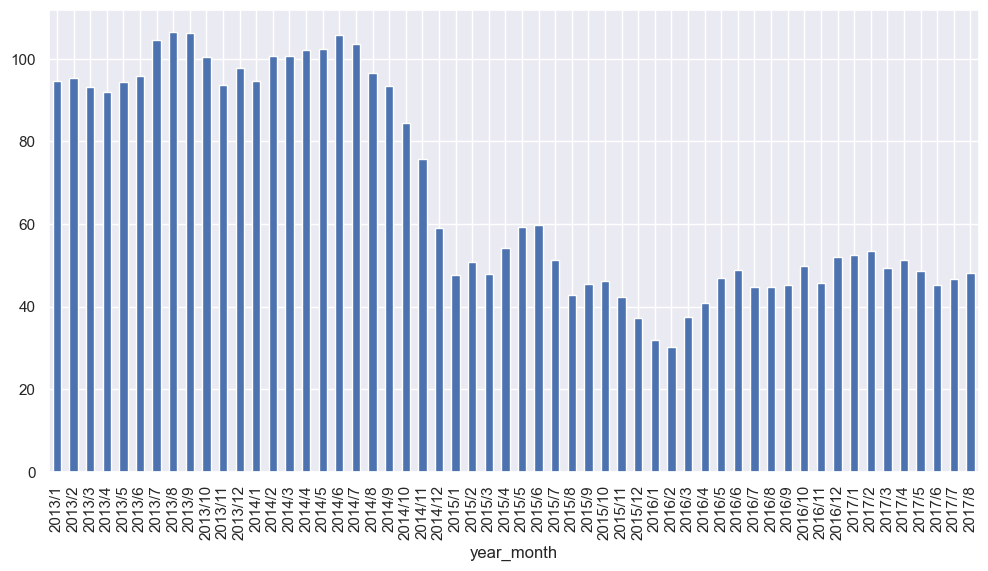

In [647]:
oil_year_month =  oil_df.groupby(['year', 'month'], as_index=False).agg({'dcoilwtico': 'mean'})

oil_year_month['year_month'] = oil_year_month.year.map(str) + '/' + oil_year_month.month.map(str)

oil_year_month.set_index('year_month').dcoilwtico.plot(kind='bar')


Заведем столбец со значениями изменения цены нефти ото дня к дню, выраженную в процентах

In [702]:
# отличный способ пройтись по всей таблице и посчитать разницу между соседними значениями 
# - с помощью метода rolling() скользящее окно 
# в качестве функции указываем разницу между соседними значениями и считаем процент разницы 

oil_df['difference_percent'] = oil_df.dcoilwtico.rolling(2).\
                                apply(lambda x: round((x.iloc[1] - x.iloc[0])/x.iloc[1]*100, 2)).\
                                fillna(0)

oil_df = oil_df[['date', 'dcoilwtico', 'difference_percent', 'year', 'month']]

oil_df

,date,dcoilwtico,difference_percent,year,month
0,2013-01-01,93.14,0.00,2013,1
1,2013-01-02,93.14,0.00,2013,1
2,2013-01-03,92.97,-0.18,2013,1
3,2013-01-04,93.12,0.16,2013,1
4,2013-01-07,93.20,0.09,2013,1
...,...,...,...,...,...
1213,2017-08-25,47.65,0.86,2017,8
1214,2017-08-28,46.40,-2.69,2017,8
1215,2017-08-29,46.46,0.13,2017,8
1216,2017-08-30,45.96,-1.09,2017,8


Примерджим в основной датасет информацию о ежедневном изменении цены на нефть в процентах

In [709]:
train_filled = train_filled.merge(oil_df[['date', 'difference_percent']], on='date', how='left').\
                            rename(columns= {'difference_percent': 'oil_price_change'})


In [712]:

train_filled

,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday,oil_price_change
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0,0.00
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0,0.00
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0,0.00
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0,0.00
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,1.0,-0.04
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,1.0,-0.04
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,1.0,-0.04
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,1.0,-0.04


### Тренировочный датасет: учитываем информацию о влиянии землетрясения 

Так как продажи после землетрясения в каждом магазине выросли на разный период (например, для магазина 1 - всего лишь в 16 неделе 2016 года, а для магазина 2 - на 16,17,18 неделях ),

то и относиться нужно к каждому магазину в частности.

такие резкие скачки в продажах - это, разумеется, выбросы и от них в выборках для обучения модели нужно избавиться

Как вариант: взять 5 недель до землетрясения (по 15 включительно), посчитать среднюю выручку, а потом сравнить эту выручку с выручкой за последующие 5 недель для каждого магазина

если разница в процентах превысит некоторое значение - исключить эти данные

<AxesSubplot: xlabel='weeks'>

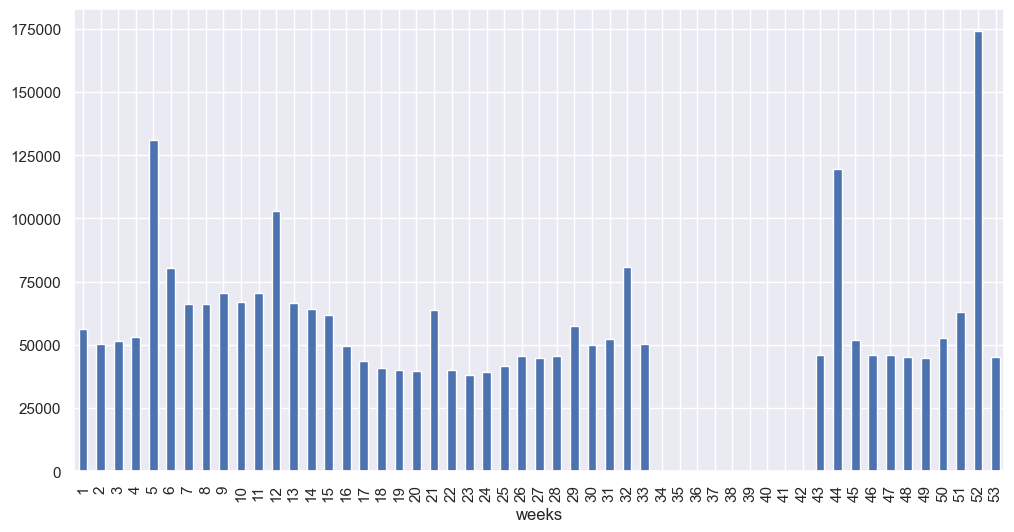

In [753]:
sales_in_year_plot(store=25, year=2016)

Кстати, 25 магазин с 34 по 42 неделю явно не работал - нулевые продажи, что тоже нельзя учитывать и нужно удалить (это выброс)

в процессе просмотра графиков выясняется, что у некоторых магазинов есть довольно длительные промежутки с нулевой выручкой. Очевидно, что магазин попросту не работал - нужно удалять эти данные из обучающей выборки

<AxesSubplot: xlabel='weeks'>

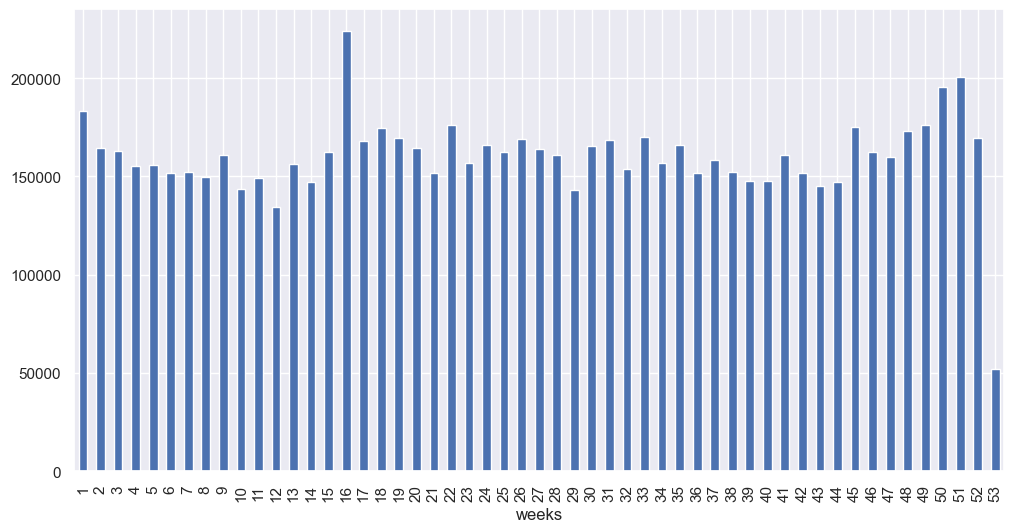

In [790]:
sales_in_year_plot(store=51, year=2016)

Некоторые даты в конце года переходят на следующую неделю, но нужно их оставить в текущем году - напишем функцию для этого

In [811]:
def stay_last_week(some_date):
    import isoweek
    if some_date.month ==12 and some_date.day in range(28,32):
        return isoweek.Week.last_week_of_year(some_date.year)[1]
    
    else:
        return some_date.isocalendar().week

Получим датасет, содержащий информацию о продажах каждого магазина в каждую неделю каждого года.

Цель:
1) выявить длительные перерывы в продажах (выбросы) для некоторых магазинов - НУЛЕВЫЕ ПРОДАЖИ
2) выявить номера недель, в которых скачок продаж после землетрясения был слишком высок (после 15 недели)

In [819]:
sales_in_weeks = train_filled.groupby(['date', 'store_nbr'], as_index=False).agg({'sales': 'sum'})

# добавим графу недели для читабельности
sales_in_weeks['weeks'] = sales_in_weeks.date.map(stay_last_week)

sales_in_weeks['year'] = sales_in_weeks.date.dt.year

sales_in_weeks = sales_in_weeks.groupby(['year', 'weeks', 'store_nbr'], as_index=False)\
                                .agg({'sales':'sum'})

sales_in_weeks
        

,year,weeks,store_nbr,sales
0,2013,1,1,27728.143012
1,2013,1,2,45267.589981
2,2013,1,3,108067.683025
3,2013,1,4,46130.453981
4,2013,1,5,44753.059040
...,...,...,...,...
13171,2017,52,50,0.000000
13172,2017,52,51,0.000000
13173,2017,52,52,0.000000
13174,2017,52,53,0.000000


Начнем с нулевых продаж за целую неделю: 
- все 54 магазина имеют такую неделю

- но сколько из них имеет нулевые продажи подряд?

Пример: магазин №20 открылся только в июле 2015 года, до этого нулевые продажи!

<AxesSubplot: xlabel='weeks'>

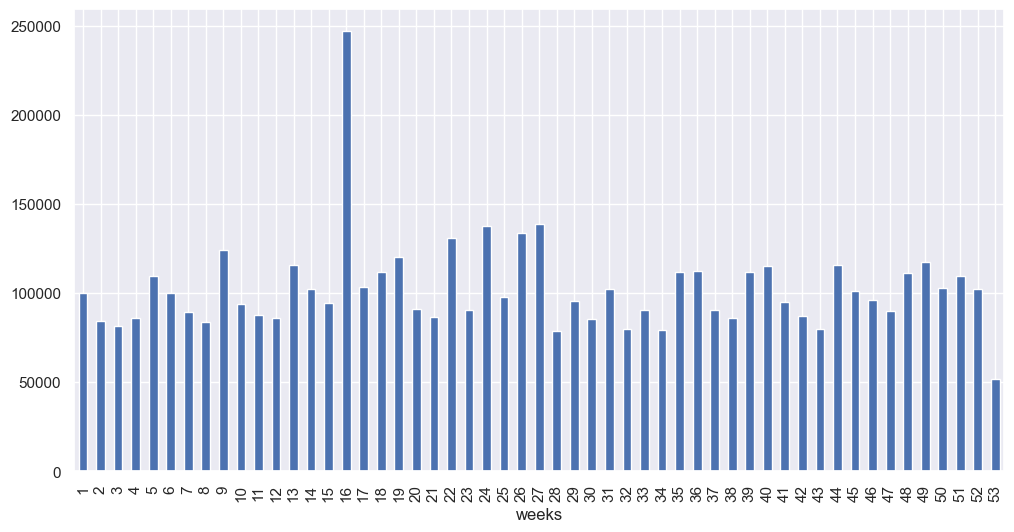

In [835]:
sales_in_year_plot(year=2016, store=20)

In [837]:
null_sales_in_a_week = sales_in_weeks[sales_in_weeks.sales == 0].sort_values(['year', 'store_nbr'])
null_sales_in_a_week

,year,weeks,store_nbr,sales
19,2013,1,20,0.0
73,2013,2,20,0.0
127,2013,3,20,0.0
181,2013,4,20,0.0
235,2013,5,20,0.0
...,...,...,...,...
12093,2017,14,52,0.0
12147,2017,15,52,0.0
13173,2017,52,52,0.0
13174,2017,52,53,0.0


Посчитаем разницу между номерами недель (нам нужно, чтобы они были соседними - это будет означать, что магазин имеет нулевые продажи две недели подряд)

In [903]:
null_sales_in_a_week['2_weeks_in_a_row'] = \
      null_sales_in_a_week.weeks.rolling(window=2).\
      apply(lambda x: x.iloc[1] - x.iloc[0]).\
                                fillna(1)

null_sales_in_a_week

,year,weeks,store_nbr,sales,2_weeks_in_a_row
19,2013,1,20,0.0,1.0
73,2013,2,20,0.0,1.0
127,2013,3,20,0.0,1.0
181,2013,4,20,0.0,1.0
235,2013,5,20,0.0,1.0
...,...,...,...,...,...
12093,2017,14,52,0.0,1.0
12147,2017,15,52,0.0,1.0
13173,2017,52,52,0.0,37.0
13174,2017,52,53,0.0,0.0


К тому же, если посмотреть на 2017 год, то дальше 33 недели продажи у всех магазинов нулевые - просто потому что у нас нет данных дальше, чем 15 августа 2017

<AxesSubplot: xlabel='weeks'>

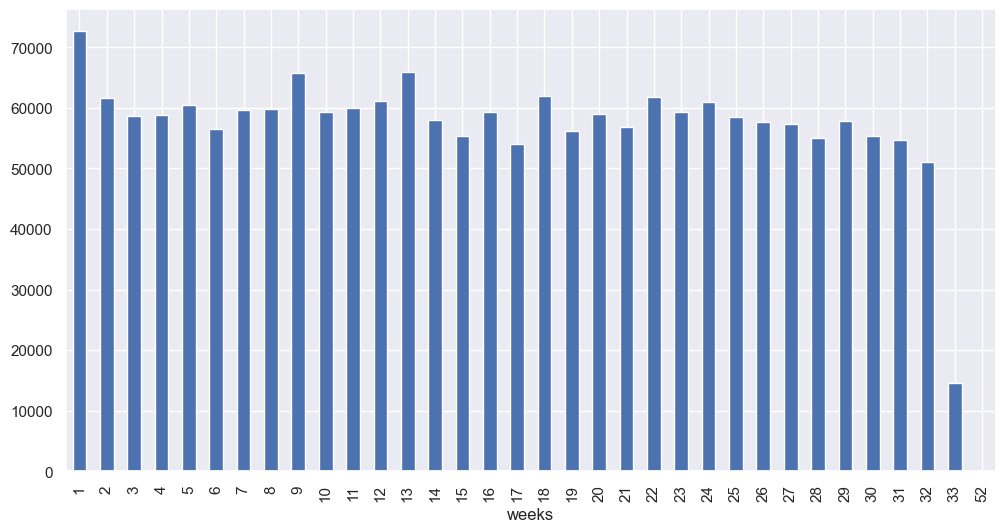

In [904]:
sales_in_year_plot(year=2017, store=23)

Еще один нюанс - 1 неделя года обычно может быть выходной, поэтому ее нулевые продажи нас не интересуют.

Уберем из рассмотрения нулевых продаж на неделе :
- 1 неделю года
- конец 2017 года

In [894]:
temp_null_weeks =  null_sales_in_a_week[(null_sales_in_a_week.weeks != 1) & \
    ~((null_sales_in_a_week.year == 2017) & (null_sales_in_a_week.weeks> 33))]

temp_null_weeks

,year,weeks,store_nbr,sales,2_weeks_in_a_row
73,2013,2,20,0.0,1.0
127,2013,3,20,0.0,1.0
181,2013,4,20,0.0,1.0
235,2013,5,20,0.0,1.0
289,2013,6,20,0.0,1.0
...,...,...,...,...,...
11931,2017,11,52,0.0,1.0
11985,2017,12,52,0.0,1.0
12039,2017,13,52,0.0,1.0
12093,2017,14,52,0.0,1.0


Получим несколько отрезков с нулевыми значениями продаж - на этих отрезках лежат две соседние недели для каждого года в каждом магазине

нам интересны только с разницей в 1 неделю, остальные - это издержки сортировки таблицы

In [895]:
temp_null_weeks['2_weeks_in_a_row'].unique()

array([  1., -24., -20., -36.,  -7., -13.])

Получим 980 недель, имеющих нулевые продажи и имеющих в соседях такую же "нулевую неделю"

In [902]:
temp_null_weeks['2_weeks_in_a_row'].value_counts()

 1.0     980
-20.0      2
-24.0      1
-36.0      1
-7.0       1
-13.0      1
Name: 2_weeks_in_a_row, dtype: int64

выкинем эти ненужные строчки,

оставим только те, что имеют соседнюю нулевую неделю (значит магазин имеет две нулевые недели подряд - и скорее всего с ним что-то не в порядке)

In [993]:
only_true_null_weeks = temp_null_weeks[~temp_null_weeks['2_weeks_in_a_row'].isin([ -24., -20., -36.,  -7., -13.])]

only_true_null_weeks['column_for_drop'] = \
    only_true_null_weeks.year.map(str) + "/" + \
    only_true_null_weeks.weeks.map(str) + "/" + \
    only_true_null_weeks.store_nbr.map(str)

only_true_null_weeks

,year,weeks,store_nbr,sales,2_weeks_in_a_row,column_for_drop
73,2013,2,20,0.0,1.0,2013/2/20
127,2013,3,20,0.0,1.0,2013/3/20
181,2013,4,20,0.0,1.0,2013/4/20
235,2013,5,20,0.0,1.0,2013/5/20
289,2013,6,20,0.0,1.0,2013/6/20
...,...,...,...,...,...,...
11931,2017,11,52,0.0,1.0,2017/11/52
11985,2017,12,52,0.0,1.0,2017/12/52
12039,2017,13,52,0.0,1.0,2017/13/52
12093,2017,14,52,0.0,1.0,2017/14/52


In [1003]:
only_true_null_weeks[only_true_null_weeks.column_for_drop == '2017/33/9']

,year,weeks,store_nbr,sales,2_weeks_in_a_row,column_for_drop


здесь оставлены только те недели для магазинов, в которые они не работали более 1 недели подряд.

мои размышления:
- самое простое - это магазин только открылся (выручка появляется только с какой-то недели какого-то года, до этого сплошные нули)
- если внезапно пошли нули, а потом снова выручка есть - скорее всего магазин был на ремонте

вывод: все эти недели для конкретных магазинов можно безболезненно удалить, более того - необходимо. нулевые продажи не помогут нам нормально обучить модель

еще одно наблюдение: 52 магазин открылся только на 16 неделе 2017 года (остальное время нулевые продажи)

        ...

Добавим в тренировочный датасет искусственный столбец вида "год-неделя-магазин" 

Цель: отфильтровать итоговый датасет так, чтобы строчек с этими неделями для некоторых магазинов попросту не стало - ведь это недели нулевых продаж

In [995]:
train_without_null_weeks = train_filled.copy()

train_without_null_weeks['week'] = train_without_null_weeks.date.dt.isocalendar().week

train_without_null_weeks['year'] = train_without_null_weeks.date.dt.year

train_without_null_weeks['column_for_drop'] = \
    train_without_null_weeks.year.map(str) + "/" + \
    train_without_null_weeks.week.map(str) + "/" + \
    train_without_null_weeks.store_nbr.map(str)

train_without_null_weeks

,id,date,store_nbr,family,onpromotion,sales,city,state,workday,oil_price_change,salary_day,week,year,column_for_drop
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
1,1,2013-01-01,1,BABY CARE,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
2,2,2013-01-01,1,BEAUTY,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
3,3,2013-01-01,1,BEVERAGES,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
4,4,2013-01-01,1,BOOKS,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,Quito,Pichincha,1.0,-0.04,1,33,2017,2017/33/9
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,Quito,Pichincha,1.0,-0.04,1,33,2017,2017/33/9
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,Quito,Pichincha,1.0,-0.04,1,33,2017,2017/33/9
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,Quito,Pichincha,1.0,-0.04,1,33,2017,2017/33/9


Теперь остается дропнуть те строки, которые содержат в себе даты из нулевых недель для конкретных магазинов в конкретном году - мы сделаем это фильтрацией(условие отрицания наличия в датасете нулевых недель)  и перезапишем датафрейм

Осталось 2 775 267 наблюдений

In [1006]:
train_cleaned_null_sales = \
train_without_null_weeks[~(train_without_null_weeks.column_for_drop.\
                         isin(only_true_null_weeks.column_for_drop))]\
                         .drop('column_for_drop', axis=1)

train_cleaned_null_sales

,id,date,store_nbr,family,onpromotion,sales,city,state,workday,oil_price_change,salary_day
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,Quito,Pichincha,0.0,0.00,0
1,1,2013-01-01,1,BABY CARE,0,0.000,Quito,Pichincha,0.0,0.00,0
2,2,2013-01-01,1,BEAUTY,0,0.000,Quito,Pichincha,0.0,0.00,0
3,3,2013-01-01,1,BEVERAGES,0,0.000,Quito,Pichincha,0.0,0.00,0
4,4,2013-01-01,1,BOOKS,0,0.000,Quito,Pichincha,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,Quito,Pichincha,1.0,-0.04,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,Quito,Pichincha,1.0,-0.04,1
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,Quito,Pichincha,1.0,-0.04,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,Quito,Pichincha,1.0,-0.04,1


Теперь займемся резкими скачками в продажах из-за землетрясения

In [1007]:
sales_in_weeks

,year,weeks,store_nbr,sales
0,2013,1,1,27728.143012
1,2013,1,2,45267.589981
2,2013,1,3,108067.683025
3,2013,1,4,46130.453981
4,2013,1,5,44753.059040
...,...,...,...,...
13171,2017,52,50,0.000000
13172,2017,52,51,0.000000
13173,2017,52,52,0.000000
13174,2017,52,53,0.000000


In [1018]:
# - оставим только 2016 год и только промежуток с 10 по 20 неделю
# - уберем все нулевые продажи 
# - округлим продажи для удобства восприятия

sales_equake =  sales_in_weeks[(sales_in_weeks.year == 2016) & (sales_in_weeks.weeks.isin(range(10,21))) & (sales_in_weeks.sales != 0)]

sales_equake = sales_equake.round(2)

sales_equake

,year,weeks,store_nbr,sales
8964,2016,10,1,70768.53
8965,2016,10,2,104385.46
8966,2016,10,3,251901.84
8967,2016,10,4,91358.23
8968,2016,10,5,68568.36
...,...,...,...,...
9552,2016,20,49,225250.76
9553,2016,20,50,123995.46
9554,2016,20,51,164327.53
9556,2016,20,53,133946.93


Разделим на две части:
- до землетрясения (считаем среднее значение выручки за 5 недель с 10 по 15 неделю)
- смотрим на выручку после землетрясения (3 следующих недели)

если после землетрясения продажи выросли более, чем на 20% - то это выброс

In [1035]:
ten_fifteen = sales_equake[sales_equake.weeks.isin(range(10,16))].\
    groupby(['store_nbr'], as_index=False).\
    agg({'sales': 'mean'}).\
    rename(columns= {'sales': 'mean_sales_before'})\
    .round(2)

# получаем таблицу средних значений продаж за 5 недель до землетрясения
ten_fifteen.head()

,store_nbr,mean_sales_before
0,1,70581.07
1,2,107505.96
2,3,256720.92
3,4,94319.42
4,5,66956.70


In [1052]:
sixteen_nineteen = sales_equake[sales_equake.weeks.isin(range(16,19))]

# примерджим таблицу со средними значениями

sharp_jump_equake = sixteen_nineteen.merge(ten_fifteen, how='left', on = 'store_nbr')

# резкий скачок в цене - больше 20% от средней за последние 5 недель
sharp_jump_equake['sharp_jump'] = ((sharp_jump_equake.sales - 
                                   sharp_jump_equake.mean_sales_before) / 
                                   sharp_jump_equake.sales) >=0.2

sharp_jump_equake = sharp_jump_equake[sharp_jump_equake.sharp_jump == True]

sharp_jump_equake['column_for_drop'] = \
    sharp_jump_equake.year.map(str) + "/" + \
    sharp_jump_equake.weeks.map(str) + "/" + \
    sharp_jump_equake.store_nbr.map(str)

sharp_jump_equake



,year,weeks,store_nbr,sales,mean_sales_before,sharp_jump,column_for_drop
0,2016,16,1,107324.65,70581.07,True,2016/16/1
1,2016,16,2,183133.97,107505.96,True,2016/16/2
2,2016,16,3,335305.41,256720.92,True,2016/16/3
3,2016,16,4,118014.23,94319.42,True,2016/16/4
5,2016,16,6,169222.26,127256.42,True,2016/16/6
6,2016,16,7,190462.66,143499.12,True,2016/16/7
7,2016,16,8,220284.55,153073.98,True,2016/16/8
8,2016,16,9,180836.21,130098.73,True,2016/16/9
9,2016,16,10,58941.17,44388.98,True,2016/16/10
11,2016,16,12,71456.04,52878.01,True,2016/16/12


Удаляем все строки из тренировочного датасета, которые отражают резкий скачок в продажах **ПОСЛЕ ЗЕМЛЕТРЯСЕНИЯ**

In [1048]:
train_cleaned_null_sales['weeks'] = train_cleaned_null_sales.date.dt.isocalendar().week

train_cleaned_null_sales['year'] = train_cleaned_null_sales.date.dt.year

train_cleaned_null_sales['column_for_drop'] = \
    train_cleaned_null_sales.year.map(str) + "/" + \
    train_cleaned_null_sales.weeks.map(str) + "/" + \
    train_cleaned_null_sales.store_nbr.map(str)

train_cleaned_null_sales

,id,date,store_nbr,family,onpromotion,sales,city,state,workday,oil_price_change,salary_day,weeks,year,column_for_drop
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
1,1,2013-01-01,1,BABY CARE,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
2,2,2013-01-01,1,BEAUTY,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
3,3,2013-01-01,1,BEVERAGES,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
4,4,2013-01-01,1,BOOKS,0,0.000,Quito,Pichincha,0.0,0.00,0,1,2013,2013/1/1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,Quito,Pichincha,1.0,-0.04,1,33,2017,2017/33/9
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,Quito,Pichincha,1.0,-0.04,1,33,2017,2017/33/9
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,Quito,Pichincha,1.0,-0.04,1,33,2017,2017/33/9
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,Quito,Pichincha,1.0,-0.04,1,33,2017,2017/33/9


In [1053]:
train_prepared = \
train_cleaned_null_sales[~(train_cleaned_null_sales.column_for_drop.\
                         isin(sharp_jump_equake.column_for_drop))]\
                         .drop(['weeks', 'year', 'column_for_drop'], axis=1)

train_prepared

,id,date,store_nbr,family,onpromotion,sales,city,state,workday,oil_price_change,salary_day
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,Quito,Pichincha,0.0,0.00,0
1,1,2013-01-01,1,BABY CARE,0,0.000,Quito,Pichincha,0.0,0.00,0
2,2,2013-01-01,1,BEAUTY,0,0.000,Quito,Pichincha,0.0,0.00,0
3,3,2013-01-01,1,BEVERAGES,0,0.000,Quito,Pichincha,0.0,0.00,0
4,4,2013-01-01,1,BOOKS,0,0.000,Quito,Pichincha,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,Quito,Pichincha,1.0,-0.04,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,Quito,Pichincha,1.0,-0.04,1
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,Quito,Pichincha,1.0,-0.04,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,Quito,Pichincha,1.0,-0.04,1


Проверим таблицу на наличие незаполненных ячеек  - они обнаружатся в столбце изменения цены на нефть.

Причина - у нас нет сведений о ценах на нефть в выходные.

Почему? биржа закрыта, а значит на выходных цена ровно та, что была зафиксирована в пятницу.

Вывод - все пустые значения в этой графе можно заполнить нулями

In [1092]:
train_prepared.isna().value_counts()

id     date   store_nbr  family  onpromotion  sales  city   state  workday  oil_price_change  salary_day
False  False  False      False   False        False  False  False  False    False             False         1975578
                                                                            True              False          789756
dtype: int64

In [1093]:
train_prepared =  train_prepared.fillna(0)

In [1094]:
train_prepared.isna().value_counts()

id     date   store_nbr  family  onpromotion  sales  city   state  workday  oil_price_change  salary_day
False  False  False      False   False        False  False  False  False    False             False         2765334
dtype: int64

### Работа с моделью

Все, таблица данных подготовлена.

Остается сделать следующее:

- разделить подготовленные данные на тестовую и тренировочную выборки

- выбрать модель, подобрать параметры модели, обучить модель не тренировочной выборке

- предсказать значения продаж для тестовой выборки, сравнить ее с тестовыми значениями

- посчитать точность модели, построить roc-кривую 

- подкрутить модель, если нужно, запустить для Итоговых тестовых данных 

- загрузить результат на сайт kaggle